In [442]:
%load_ext autoreload
%autoreload 2
from new_aeb_gplvm import *
import warnings
import json
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.distributions import kl_divergence

warnings.filterwarnings("ignore")
# import the necessary package
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dataset_list = os.listdir("datasets/Classical")


def fix_name(name):
    fixed = name.replace(".npz", "")
    return fixed


datasets = list(map(fix_name, dataset_list))

In [3]:
df_hyper = pd.read_json("experiments/complete/gplvm/000_gplvm_normal_03_best.json")

In [4]:
def get_hypers(dataset):
    hypers = df_hyper[df_hyper.dataset == dataset]
    hp = hypers[
        [
            "kernel",
            "batch_size",
            "learning_rate",
            "latent_dim",
            "layers",
            "n_inducing",
            "n_epochs",
        ]
    ].to_dict(orient="records")
    return hp[0]

In [5]:
from baseline.PyOD import PYOD

model_dict = {"GPLVM": AD_GPLVM}

In [6]:
# datasets_ruins = [
#    "22_magic.gamma",
#    "33_skin",
# ]
# datasets_medianos = [
#    "41_Waveform",
#    "36_speech",
# ]
# datasets_bons = [
#    "16_http",
#    "21_Lymphography",
# ]
# datasets = datasets_ruins + datasets_medianos + datasets_bons

In [506]:
# seed for reproducible results
dataset = datasets[4]
seed = 42
df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
# import the dataset
datagenerator.dataset = dataset  # specify the dataset name
data = datagenerator.generator(
    la=1.00,
    realistic_synthetic_mode=None,
    noise_type=None,
    stdscale=True,
    minmax=False,
)
ratio = data["y_train"].sum() / len(data["y_train"])
Y_train, Y_test, lb_train, lb_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)
hp = get_hypers(dataset)
dataset, ratio

subsampling for dataset 05_campaign...


('05_campaign', 0.11028571428571429)

In [528]:
clf = AD_GPLVM(
    latent_dim=hp["latent_dim"],
    n_inducing=hp["n_inducing"],
    n_epochs=1000,  # hp["n_epochs"],
    nn_layers=tuple(map(int, hp["layers"].split(","))),
    lr=0.01,  # hp["learning_rate"],
    batch_size=128,  # hp["batch_size"],
    kernel=hp["kernel"],
)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

In [529]:
aucroc = []
for i in range(1):
    clf.fit(Y_train, lb_train, loss_type="hard", tune="start")
    score = clf.predict_score(Y_test)
    result = utils.metric(y_true=lb_test, y_score=score)
    aucroc.append(result["aucroc"])
print(np.mean(aucroc))

0.7215246327137471


In [530]:
loss_n = clf.loss_n
torch.topk(
    loss_n,
    k=10,
    largest = True
)

torch.return_types.topk(
values=tensor([1.0295, 1.0050, 0.9578, 0.9562, 0.9548, 0.9416, 0.9388, 0.9322, 0.9269,
        0.8755], grad_fn=<TopkBackward0>),
indices=tensor([ 29,  30, 122,  75,  83,  69,  77,  92,   4,  12]))

In [531]:
loss_a = clf.loss_a
torch.topk(
    loss_a,
    k=10,
    largest = True
)

torch.return_types.topk(
values=tensor([-0.9713, -0.9950, -1.0441, -1.0458, -1.0473, -1.0620, -1.0652, -1.0727,
        -1.0788, -1.1422], grad_fn=<TopkBackward0>),
indices=tensor([ 29,  30, 122,  75,  83,  69,  77,  92,   4,  12]))

In [532]:
# clf.lll.sum(), clf.klu.sum(), clf.klx.sum()

In [533]:
# elbo = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [534]:
# elbo(clf.pred, clf.batch)[0].sum(),elbo(clf.pred, clf.batch)[1].sum(), elbo(clf.pred, clf.batch)[3].sum()

In [535]:
# clf.klx_loe

In [536]:
# -torch.log(1 + torch.exp(torch.max(clf.loss_n)).item() - torch.exp(clf.loss_n))

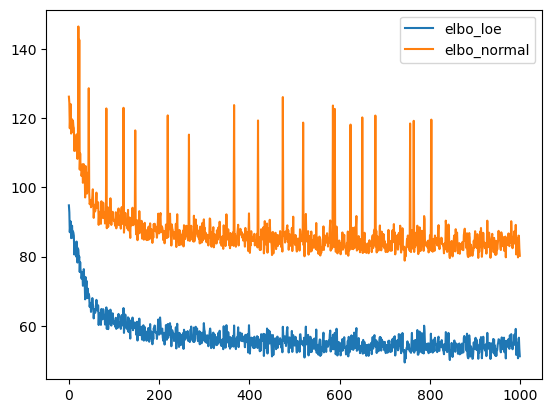

In [537]:
# plt.plot(
#   clf.lll_loe,
#   label="LL_Loe",
# )
# plt.plot(
#  clf.lll_elbo,
#  label="LL_Elbo",
# )
# plt.plot(
#    clf.klx_loe,
#    label="KLX_Loe",
# )
# plt.plot(
#   clf.klx_elbo,
#   label="KLX_Elbo",
# )
# plt.plot(
#   clf.klu_loe,
#   label="KLU_Loe",
# )
# plt.plot(
#   clf.klu_elbo,
#   label="KLU_Elbo",
# )
plt.plot(
    clf.loe_list,
   label="elbo_loe",
)
plt.plot(
    clf.loss_list,
    label="elbo_normal",
)
plt.legend()
None

In [527]:
kl_divergence(clf.encoder.kl_latent.q_x, clf.encoder.kl_latent.p_x).sum(axis=0) / (
    clf.encoder.kl_latent.n
)

tensor(1.3559)

In [498]:
Y_train = torch.tensor(Y_train, dtype=torch.float32)
sample = clf.model.sample_latent_variable(Y_train)
output = clf.model(sample)

In [123]:
clf.elbo(output, Y_train.T).sum()

tensor(-42.5673, grad_fn=<SumBackward0>)

In [124]:
elbo_x = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [125]:
ll, klu, _, klx = elbo_x(output, Y_train.T)
{
    "log_likelihood": ll,
    "ll_sum": ll.sum(),
    "klx": klx,
    "klx_sum": klx.sum(),
    "klu": klu,
    "klu_sum": klu.sum(),
    "total_sum": ll.sum() - klx.sum() - klu.sum(),
}

{'log_likelihood': tensor([-1.5695, -1.5708, -1.5703, -1.5700, -1.5688, -1.5696, -1.5694, -1.5694,
         -1.5697, -1.5705, -1.5697, -1.5696, -1.5700, -1.5695, -1.5694, -1.5696,
         -1.5691, -1.5698, -1.5701, -1.5699, -1.5698, -1.5706, -1.5703, -1.5698,
         -1.5695, -1.5698, -1.5698], grad_fn=<DivBackward0>),
 'll_sum': tensor(-42.3843, grad_fn=<SumBackward0>),
 'klx': tensor([0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
        grad_fn=<AddBackward0>),
 'klx_sum': tensor(0.1080, grad_fn=<SumBackward0>),
 'klu': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'kl

In [127]:
log_likelihood = (
    clf.likelihood.expected_log_prob(Y_train.T, output).sum(0).div(len(Y_train))
)
{
    "log_likelihood": log_likelihood,
    "log_likelihood_sum": log_likelihood.sum(),
}

{'log_likelihood': tensor([-0.0045, -0.0045, -0.0048,  ..., -0.0044, -0.0042, -0.0050],
        grad_fn=<DivBackward0>),
 'log_likelihood_sum': tensor(-42.3843, grad_fn=<SumBackward0>)}

In [128]:
klu_expanded = clf.model.variational_strategy.kl_divergence().div(len(Y_train))
{
    "klu_expanded": klu_expanded,
    "klu_expanded_sum": klu_expanded.sum(),
}

{'klu_expanded': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'klu_expanded_sum': tensor(0.0750, grad_fn=<SumBackward0>)}

In [45]:
klu_zero = torch.zeros_like(Y_train)
klu_zero

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
added_loss = torch.zeros_like(log_likelihood)
for added_loss_term in clf.model.added_loss_terms():
    added_loss.add_(added_loss_term.loss())
added_loss.sum()

tensor(26.7473, grad_fn=<SumBackward0>)

In [ ]:
contamination = lb_train.sum() / len(lb_train)